# Import Libraries

In [1]:

import os
from IPython import get_ipython
get_ipython().run_line_magic("matplotlib", "inline")
from torchvision.transforms import Compose, Resize, InterpolationMode, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip
import torch
from code.classifier import CNNPneumoniaClassifier, Config
from code.plot_random_image import plot_random_image_from_loader
from code.classify_random_images import plot_random_images_with_labels
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt



C:\Users\aszab\miniconda3\envs\classifier\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Load the TensorBoard
%reload_ext tensorboard
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
# Enable CUDA Launch Blocking
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Set float32 matrix multiplication precision to 'medium' to utilize Tensor Cores
torch.set_float32_matmul_precision('medium')
torch.serialization.add_safe_globals([Compose, Resize, set, Config, InterpolationMode, ToTensor, Normalize, RandomHorizontalFlip])

# Check GPU Availability

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Sun Jan 19 15:00:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.90                 Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti   WDDM  |   00000000:02:00.0 Off |                  N/A |
|  0%   44C    P8              6W /  285W |    1998MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Setup Model

In [5]:
config = Config(
    backbone_name="resnet18",
    transfer_learning=True,
    learning_rate=1e-4,
    batch_size=20,
    max_epochs=50,
    weight_decay=1e-4,
    dropout=0.2,
    num_workers=16,
    model_name="ResNet18_premult",
    version="001",
    optimizer_name = "sgd",
    use_class_weights=True,
    image_res=224,
    patience = 10,
    image_type=3
)
model = CNNPneumoniaClassifier(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


# Plot random images from all datasets

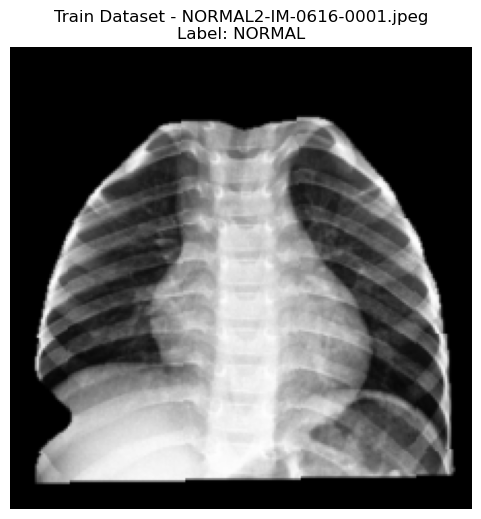

In [6]:
plot_random_image_from_loader(model.train_loader.dataset, "Train Dataset")

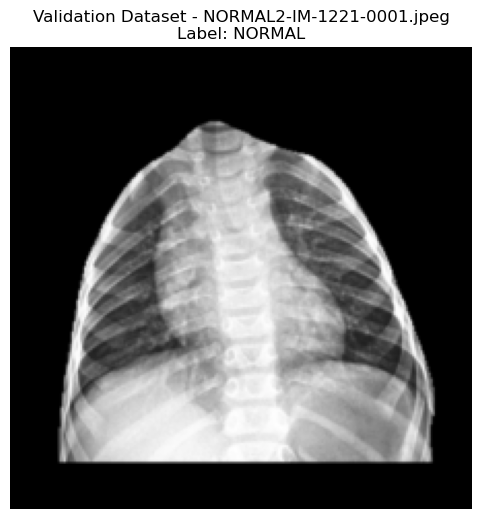

In [7]:
plot_random_image_from_loader(model.val_loader.dataset, "Validation Dataset")

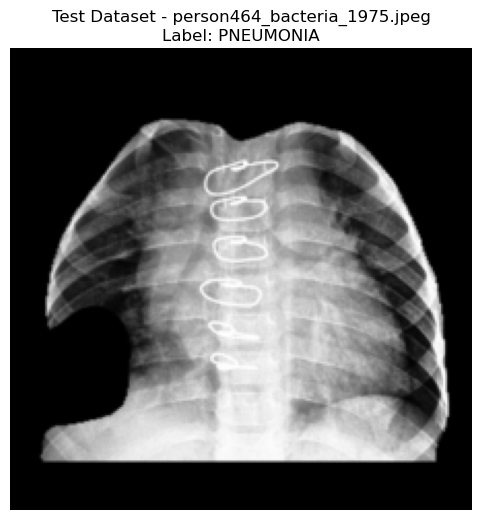

In [8]:
plot_random_image_from_loader(model.test_loader.dataset, "Test Dataset")

# Train Model

In [9]:

# Train Model - Uncomment to train model
#model.train_model()
#torch.save({
#    "state_dict": model.state_dict(),
#    "config": vars(config)
#}, f"../models/{config.model_name}_final.pt")

# Load Model

In [10]:

checkpoint = torch.load(f"../models/{config.model_name}_final.pt")
loaded_config = Config(**checkpoint["config"])
model = CNNPneumoniaClassifier(loaded_config)
model.load_state_dict(checkpoint["state_dict"])
model.eval()
model = model.to(device)

C:\Users\aszab\AppData\Local\Temp\ipykernel_13816\3427658734.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"../models/{config.model_name}_fina

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


# Test Model

In [11]:
# Run testing
print("Testing the model...")
checkpoint_path = f"../checkpoints/{config.model_name}.ckpt"
test_metadata = model.test_model(checkpoint_path)  # Ensure this uses the correct test_loader

Testing the model...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Testing:   0%|          | 0/44 [00:00<?, ?it/s]

Testing DataLoader 0:   0%|          | 0/44 [00:00<?, ?it/s]

Testing DataLoader 0:   2%|▏         | 1/44 [00:01<00:48,  0.89it/s]

Testing DataLoader 0:   5%|▍         | 2/44 [00:01<00:25,  1.64it/s]

Testing DataLoader 0:   7%|▋         | 3/44 [00:01<00:17,  2.29it/s]

Testing DataLoader 0:   9%|▉         | 4/44 [00:01<00:13,  2.87it/s]

Testing DataLoader 0:  11%|█▏        | 5/44 [00:01<00:11,  3.39it/s]

Testing DataLoader 0:  14%|█▎        | 6/44 [00:01<00:09,  3.81it/s]

Testing DataLoader 0:  16%|█▌        | 7/44 [00:01<00:08,  4.22it/s]

Testing DataLoader 0:  18%|█▊        | 8/44 [00:01<00:07,  4.61it/s]

Testing DataLoader 0:  20%|██        | 9/44 [00:01<00:07,  4.98it/s]

Testing DataLoader 0:  23%|██▎       | 10/44 [00:01<00:06,  5.30it/s]

Testing DataLoader 0:  25%|██▌       | 11/44 [00:01<00:05,  5.61it/s]

Testing DataLoader 0:  27%|██▋       | 12/44 [00:02<00:05,  5.94it/s]

Testing DataLoader 0:  30%|██▉       | 13/44 [00:02<00:04,  6.26it/s]

Testing DataLoader 0:  32%|███▏      | 14/44 [00:02<00:04,  6.56it/s]

Testing DataLoader 0:  34%|███▍      | 15/44 [00:02<00:04,  6.86it/s]

Testing DataLoader 0:  36%|███▋      | 16/44 [00:02<00:03,  7.14it/s]

Testing DataLoader 0:  39%|███▊      | 17/44 [00:02<00:03,  7.41it/s]

Testing DataLoader 0:  41%|████      | 18/44 [00:02<00:03,  7.65it/s]

Testing DataLoader 0:  43%|████▎     | 19/44 [00:02<00:03,  7.83it/s]

Testing DataLoader 0:  45%|████▌     | 20/44 [00:02<00:02,  8.02it/s]

Testing DataLoader 0:  48%|████▊     | 21/44 [00:02<00:02,  8.21it/s]

Testing DataLoader 0:  50%|█████     | 22/44 [00:02<00:02,  8.44it/s]

Testing DataLoader 0:  52%|█████▏    | 23/44 [00:02<00:02,  8.65it/s]

Testing DataLoader 0:  55%|█████▍    | 24/44 [00:02<00:02,  8.86it/s]

Testing DataLoader 0:  57%|█████▋    | 25/44 [00:02<00:02,  9.06it/s]

Testing DataLoader 0:  59%|█████▉    | 26/44 [00:02<00:01,  9.26it/s]

Testing DataLoader 0:  61%|██████▏   | 27/44 [00:02<00:01,  9.45it/s]

Testing DataLoader 0:  64%|██████▎   | 28/44 [00:02<00:01,  9.63it/s]

Testing DataLoader 0:  66%|██████▌   | 29/44 [00:02<00:01,  9.80it/s]

Testing DataLoader 0:  68%|██████▊   | 30/44 [00:03<00:01,  9.97it/s]

Testing DataLoader 0:  70%|███████   | 31/44 [00:03<00:01, 10.12it/s]

Testing DataLoader 0:  73%|███████▎  | 32/44 [00:03<00:01, 10.28it/s]

Testing DataLoader 0:  75%|███████▌  | 33/44 [00:03<00:01, 10.44it/s]

Testing DataLoader 0:  77%|███████▋  | 34/44 [00:03<00:00, 10.58it/s]

Testing DataLoader 0:  80%|███████▉  | 35/44 [00:03<00:00, 10.73it/s]

Testing DataLoader 0:  82%|████████▏ | 36/44 [00:03<00:00, 10.87it/s]

Testing DataLoader 0:  84%|████████▍ | 37/44 [00:03<00:00, 11.01it/s]

Testing DataLoader 0:  86%|████████▋ | 38/44 [00:03<00:00, 11.14it/s]

Testing DataLoader 0:  89%|████████▊ | 39/44 [00:03<00:00, 11.27it/s]

Testing DataLoader 0:  91%|█████████ | 40/44 [00:03<00:00, 11.40it/s]

Testing DataLoader 0:  93%|█████████▎| 41/44 [00:03<00:00, 11.52it/s]

Testing DataLoader 0:  95%|█████████▌| 42/44 [00:03<00:00, 11.64it/s]

Testing DataLoader 0:  98%|█████████▊| 43/44 [00:03<00:00, 11.76it/s]

Testing DataLoader 0: 100%|██████████| 44/44 [00:03<00:00, 11.80it/s]

Testing DataLoader 0: 100%|██████████| 44/44 [00:03<00:00, 11.08it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.9283276200294495     │
│       test_f1_epoch       │    0.9496402740478516     │
│   test_precision_epoch    │    0.9737704992294312     │
│     test_recall_epoch     │    0.9266770482063293     │
│  test_specificity_epoch   │    0.9327731132507324     │
└───────────────────────────┴───────────────────────────┘

# Plot Confusion Matrix

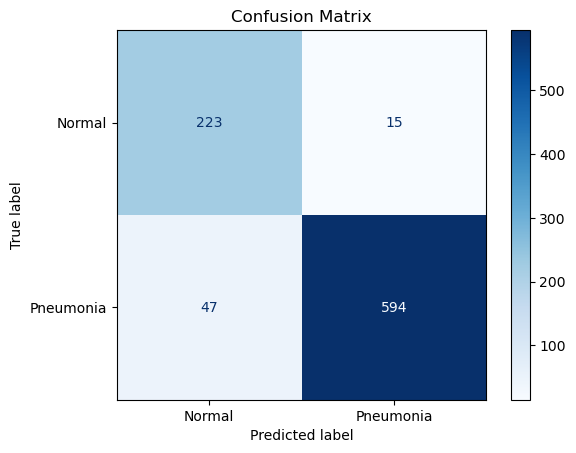

In [12]:
def plot_confusion_matrix(model, dataloader, class_names):
    all_preds = []
    all_labels = []

    # Get predictions and true labels
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for data, labels, _ in dataloader:
            data = data.cuda()  # Move data to GPU if available
            labels = labels.cuda()
            preds = torch.argmax(model(data), dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

# Call this after training/testing
plot_confusion_matrix(model, model.test_loader, class_names=["Normal", "Pneumonia"])

# Plot ROC/AUC Score

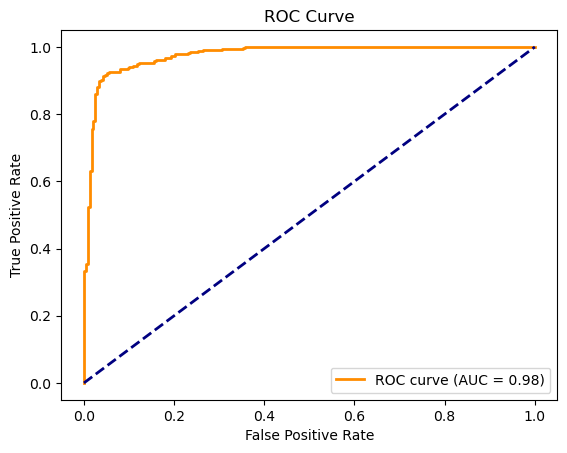

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_auc(model, dataloader):
    all_preds = []
    all_labels = []

    # Get predictions and true labels
    model.eval()
    with torch.no_grad():
        for data, labels, _ in dataloader:
            data = data.cuda()
            labels = labels.cuda()
            preds = model(data)
            probs = torch.softmax(preds, dim=1)[:, 1]  # Probabilities for class 1
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc(model, model.test_loader)

# Plot Gradcam

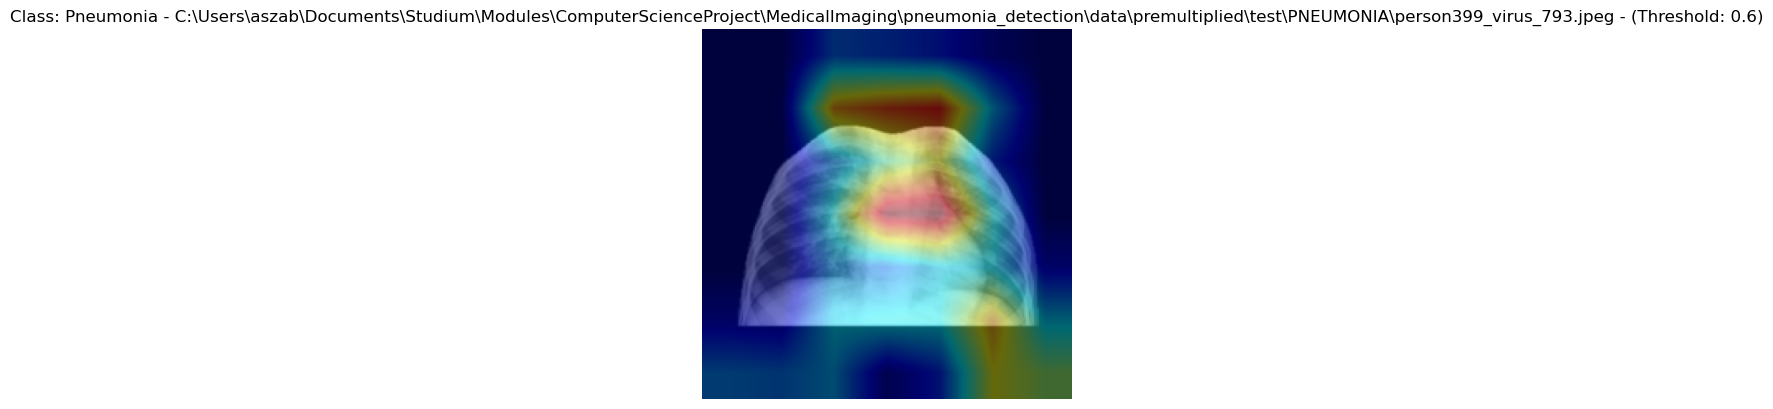

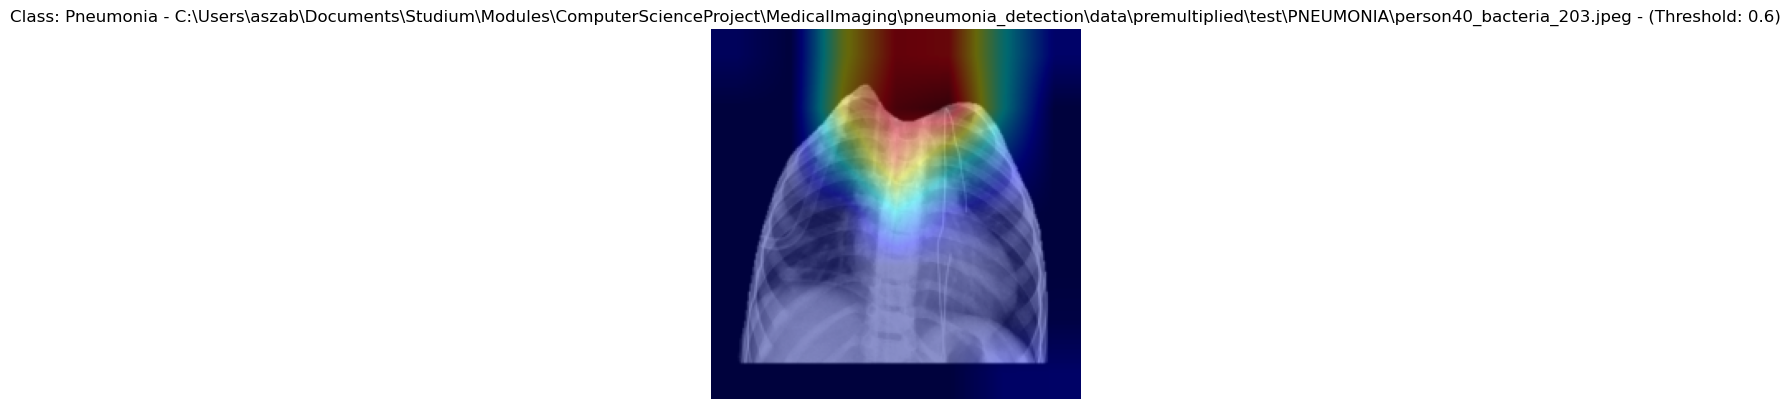

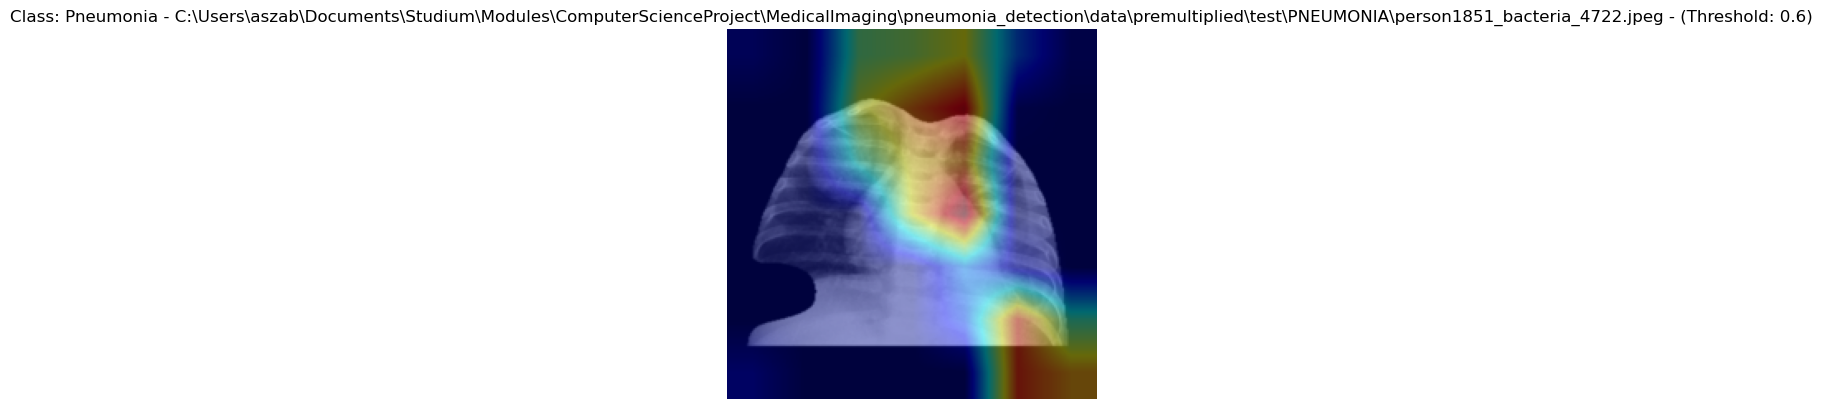

In [14]:
for param in model.feature_extractor.parameters():
    param.requires_grad = True
model.visualize_gradcam(num_samples=4, target_layer=7, class_names=["Normal", "Pneumonia"], threshold=0.6)


# Evaluate Metrics in Tensorboard

In [15]:
# Load TensorBoard extension
%load_ext tensorboard

# Specify the log directory
log_dir = f"tb_logs/{config.model_name}"

# Start TensorBoard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 28012), started 1 day, 8:41:29 ago. (Use '!kill 28012' to kill it.)

# Classify random images

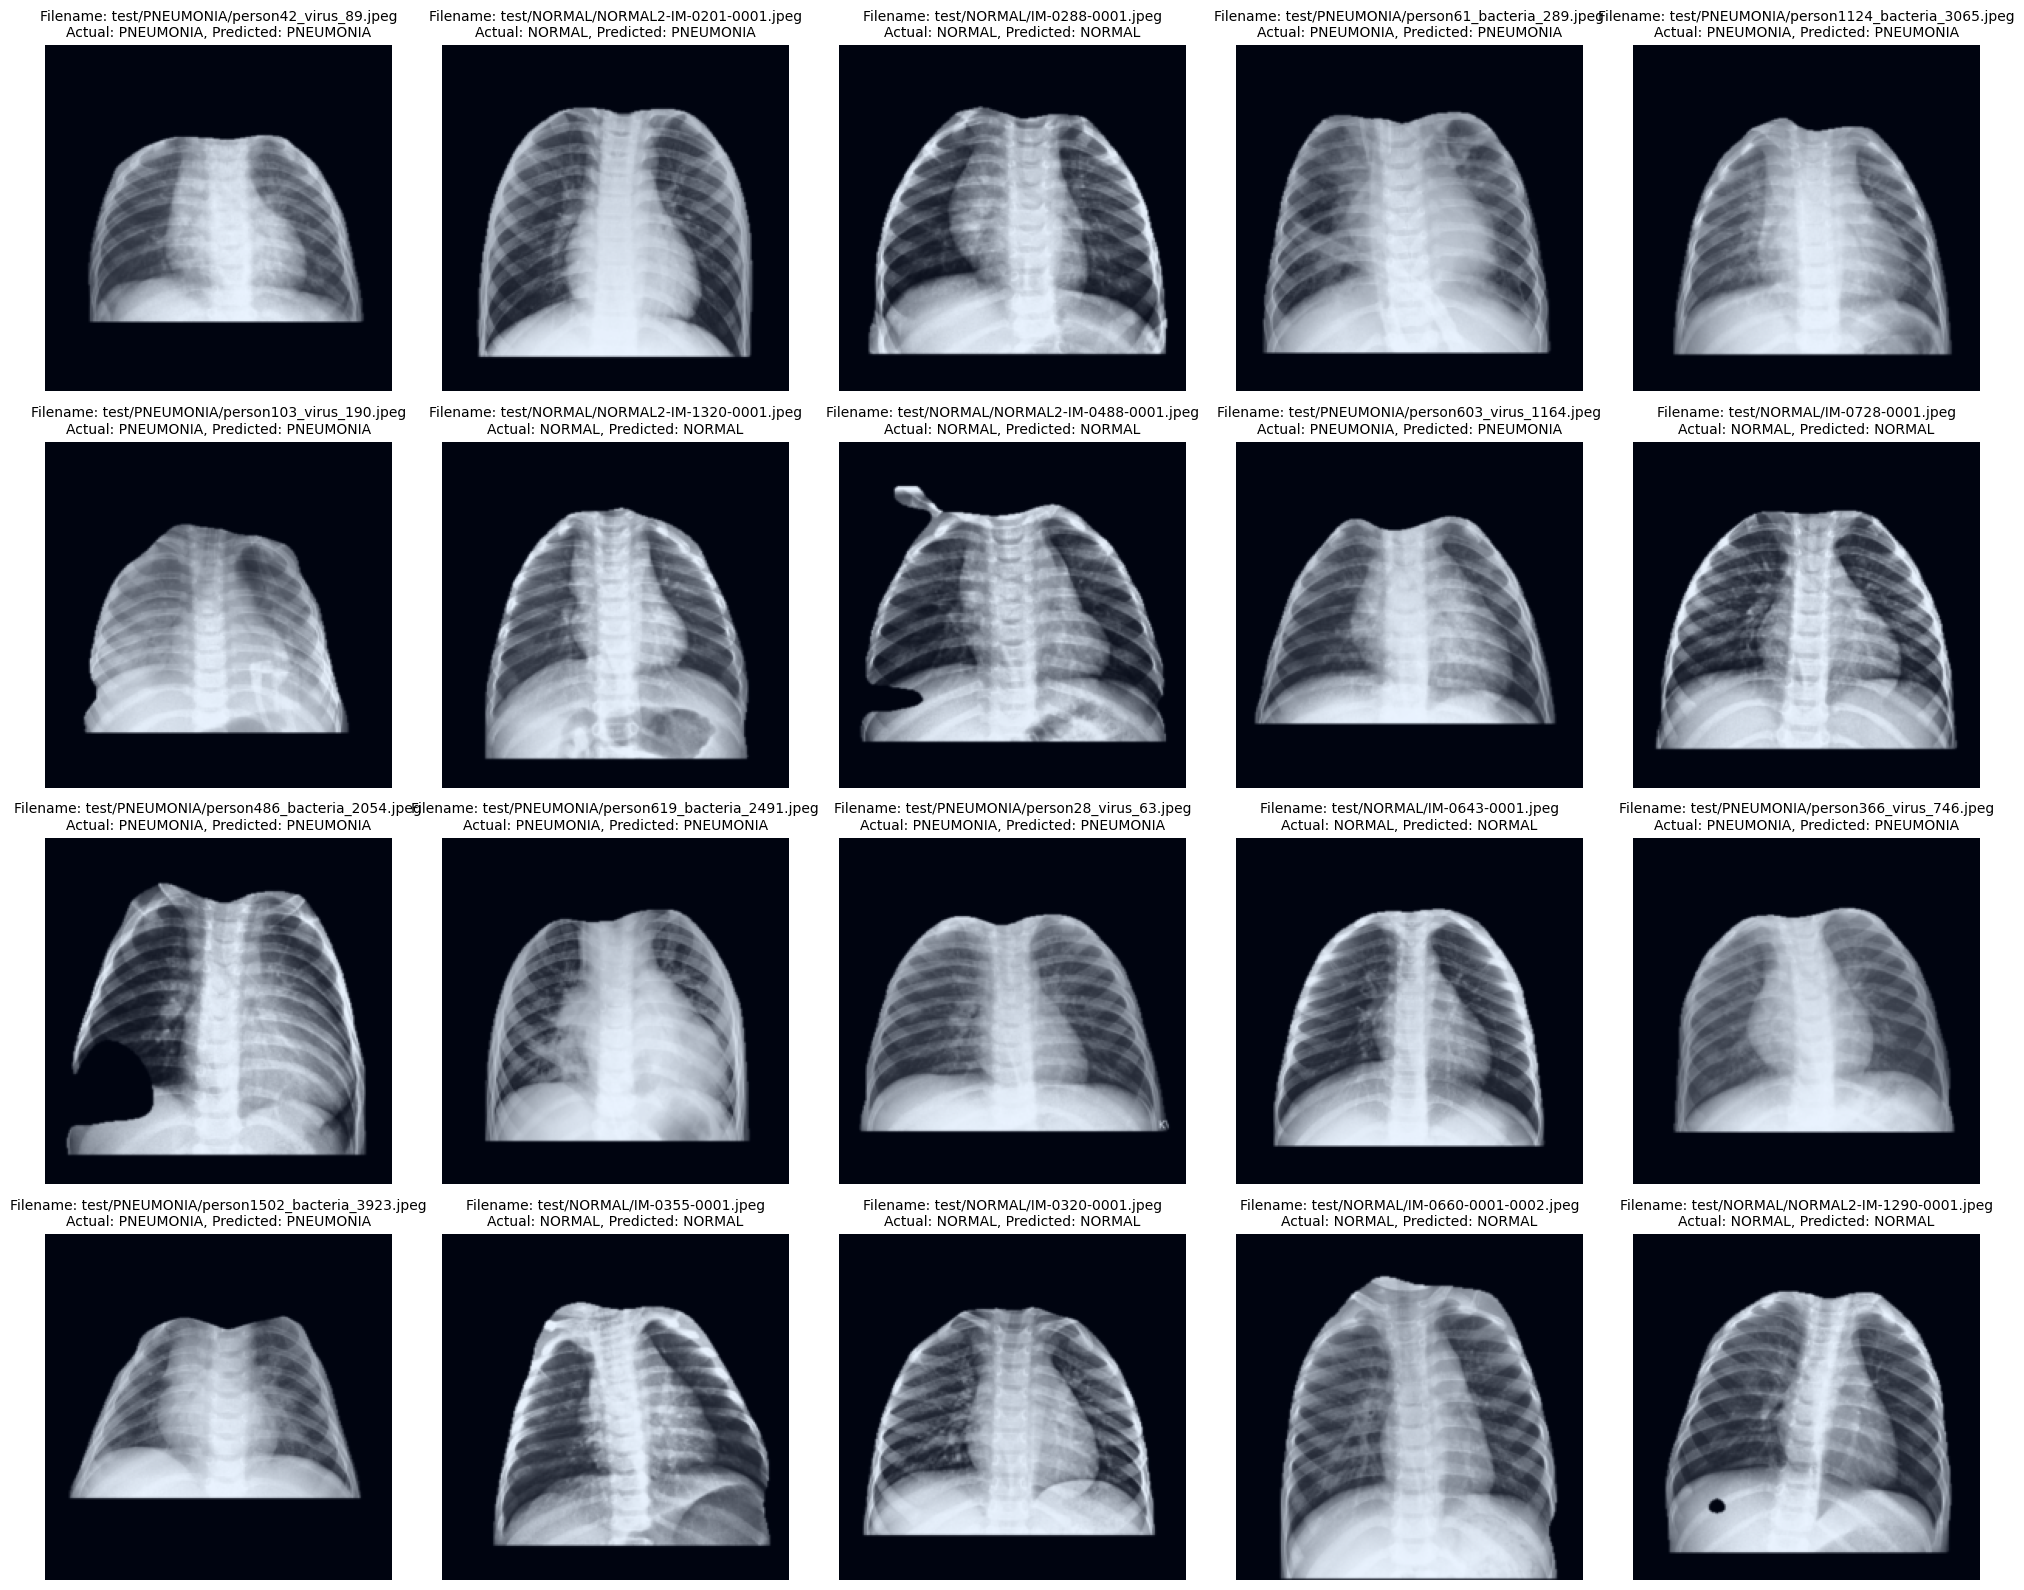

In [16]:
plot_random_images_with_labels(model, model.test_loader, num_images=20)